In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data

In [2]:
def getCloseData(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)['Close']

def getCloseDataPandas(ticker, start, end):
    return data.get_data_yahoo(ticker, start, end)['Close']


def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)


def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]


def getPortfolioResult(closeDataSet, weight=None):

    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)

    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


def getEvaluation(cumulativeReturn):

    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()

    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd


def getRebalancingDate(closeDataSet, period="month"):

    data = closeDataSet.copy()
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    # 월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index

    return rebalancingDate


def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)]
                                * len(rebalancingDate),index=rebalancingDate,columns=closeDataSet.columns)
        
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[end] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


def getWeightByAvgMomentumScore(closeDataSet, n = 12, empty_exist=False):

    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    
    if empty_exist == True:
        # Momentum 계산을 안하는 구간 생성
        # Momentum Avg에 포함되지 않는 DataFrame 생성
        df_momentum_empty = pd.DataFrame(index=priceOnRebalDate.index[:n], columns=priceOnRebalDate.columns).fillna(0)
        df_weight_empty = pd.DataFrame(index=priceOnRebalDate.index[:n], columns=priceOnRebalDate.columns).fillna(0)     
    elif empty_exist == False:
        print('no empty period')
        
    # n개월 모멘텀스코어 계산
    # Momentum Avg 저장할 DataFrame 생성
    df_momentum_avg = pd.DataFrame(index=priceOnRebalDate.index[n:], columns=priceOnRebalDate.columns)

    for stock in priceOnRebalDate.columns:
        MomentumScore = 0
        TotalMomentumScore = 0

        for i in range(n, len(priceOnRebalDate)):
            MomentumScore = 0
            TotalMomentumScore = 0

            for j in range(i-n, i):
                # 모멘텀 총합 계산
                TotalMomentumScore += np.where(priceOnRebalDate[stock][i] / priceOnRebalDate[stock][j] > 1, 1, 0)

            AvgMomentumScore = TotalMomentumScore / n

            df_momentum_avg.loc[str(priceOnRebalDate.index[i])[:10]][stock] = AvgMomentumScore

    try:
        # momentum score에 포함되지 않은 날짜 재포함한 DataFrame
        df_all_momentum_avg = pd.concat([df_momentum_empty, df_momentum_avg], axis=0)
    
    except:
        df_all_momentum_avg = df_momentum_avg.copy()
    
    # Momentum Avg 기반 가중치 할당
    df_weight = pd.DataFrame(index = df_momentum_avg.index, columns=df_momentum_avg.columns) # 가중치를 저장할 DataFrame 생성
    df_weight_dollar = pd.DataFrame(index = df_momentum_avg.index, columns=['dollar']) # 달러 ETF 가중치 DataFrame 생성
    df_weight_cash = pd.DataFrame(index = df_momentum_avg.index, columns=['cash']) # 현금 가중치 DataFrame 생성
    for date in df_weight.index:
        '''
       달러 가중치 계산법
        kodex200의 Momentum Avg와 kodex10Bond의 Momentum Avg의 비율을 기반으로 가중치를 할당한다.
        
        -----------------------
        주식 평균 모멘텀 스코어 : 0.2
        장기 채권 평균 모멘텀 스코어 : 0.1
        현금 평균 모멘텀 스코어 : 1 (항상 1로 고정)
        
        주식 비중 (달러로 대치하여 투자) : 0.8 (1-0.2)
        장기채 비중 (달러로 대치하여 투자) : 0.9 (1-0.1)
        현금 : 1
        ------------------------
        '''
        #print("\n##########\n")
        date = str(date)[:10] # 날짜 재설정 (그냥 사용하면 datetime 형식이기 때문에 사용하기 까다롭다)
        #print("{}을 기준으로 한 가중치 배분".format(date))

        total_weight = sum(df_momentum_avg.loc[date]) # Momentum Avg의 총합

        # kodex200 & kodex10Bond의 평균 모멘텀 스코어의 평균이 0.3 미만인 경우
        if total_weight / 2 < 0.3:
            dollar = (1 - df_momentum_avg.loc[date]['kodex200']) + (1 - df_momentum_avg.loc[date]['kodex10Bond'])
            cash = 1
            df_weight_dollar.loc[date] = dollar / (dollar + cash)
            df_weight_cash.loc[date] = cash / (dollar + cash)
            df_weight.loc[date]['kodex200'] = 0.0
            df_weight.loc[date]['kodex10Bond'] = 0.0
        # kodex200 & kodex10Bond의 평균 모멘텀 스코어의 평균이 0.3 이상인 경우
        else:
            df_weight_dollar.loc[date] = 0.0
            df_weight_cash.loc[date] = 0.0
            # kodex200의 가중치
            kodex200_w = df_momentum_avg.loc[date]['kodex200'] / total_weight
            df_weight.loc[date]['kodex200'] = kodex200_w

            # kodex10Bond의 가중치
            kodex10Bond_w = df_momentum_avg.loc[date]['kodex10Bond'] / total_weight
            df_weight.loc[date]['kodex10Bond'] = kodex10Bond_w

        #print("kodex200 : {} / kodex10Bond : {}".format(kodex200_w, kodex10Bond_w))

    try:
        # momentum score에 포함되지 않은 날짜 재포함한 DataFrame
        df_all_weight = pd.concat([df_weight_empty, df_weight], axis=0)

    except:
        df_all_weight = df_weight.copy()
    # 모든 가중치 DataFrame을 하나로 합치기
    df_all_weight = pd.concat([df_all_weight, df_weight_dollar, df_weight_cash], axis=1)

    return df_all_weight, df_all_momentum_avg

In [3]:
kodex200 = getCloseData("069500", "2017-9", "2022-9-30") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2017-9", "2022-9-30") # 국고채 10년 ETF
dollar = getCloseData("261240", "2017-9", "2022-9-30") # 달러 ETF

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet.dropna(inplace=True)
closeDataSet

,kodex200,kodex10Bond
Date,,
2017-09-01,27831,65360
2017-09-04,27522,65140
2017-09-05,27495,65130
2017-09-06,27435,65320
2017-09-07,27779,65300
...,...,...
2022-09-26,29050,59390
2022-09-27,29105,59915
2022-09-28,28390,59775


In [4]:
rebalDate = getRebalancingDate(closeDataSet)
priceOnRebalDate = closeDataSet.loc[rebalDate]
priceOnRebalDate

,kodex200,kodex10Bond
Date,,
2017-09-29,28636,64810
2017-10-31,30178,63935
2017-11-30,29419,64485
2017-12-28,29640,64545
2018-01-31,30475,63130
...,...,...
2022-05-31,35363,63640
2022-06-30,30808,62025
2022-07-29,32385,64915


In [5]:
weight12, avgMomentumScore12 = getWeightByAvgMomentumScore(closeDataSet, n=12)

no empty period


In [6]:
avgMomentumScore12

,kodex200,kodex10Bond
Date,,
2018-09-28,0.25,0.916667
2018-10-31,0.0,1.0
2018-11-30,0.083333,1.0
2018-12-28,0.083333,1.0
2019-01-31,0.25,0.916667
2019-02-28,0.25,0.916667
2019-03-29,0.25,1.0
2019-04-30,0.416667,0.916667
2019-05-31,0.166667,1.0


In [7]:
weight12

,kodex200,kodex10Bond,dollar,cash
Date,,,,
2018-09-28,0.214286,0.785714,0.0,0.0
2018-10-31,0.0,1.0,0.0,0.0
2018-11-30,0.076923,0.923077,0.0,0.0
2018-12-28,0.076923,0.923077,0.0,0.0
2019-01-31,0.214286,0.785714,0.0,0.0
2019-02-28,0.214286,0.785714,0.0,0.0
2019-03-29,0.2,0.8,0.0,0.0
2019-04-30,0.3125,0.6875,0.0,0.0
2019-05-31,0.142857,0.857143,0.0,0.0


In [8]:
closeDataSet = pd.concat([closeDataSet, dollar], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond', 'dollar']
closeDataSet['cash'] = 1
closeDataSet.dropna(inplace=True)

closeDataSet

,kodex200,kodex10Bond,dollar,cash
Date,,,,
2017-09-01,27831,65360,9430,1
2017-09-04,27522,65140,9510,1
2017-09-05,27495,65130,9495,1
2017-09-06,27435,65320,9525,1
2017-09-07,27779,65300,9485,1
...,...,...,...,...
2022-09-26,29050,59390,12720,1
2022-09-27,29105,59915,12640,1
2022-09-28,28390,59775,12795,1


In [9]:
# 달러 ETF 포함 리밸런싱
_, momentum12CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight12)
print(f"달러 ETF 포함 리밸런싱 최종수익률: {momentum12CumReturn.iloc[-1]}")
cagr12, dd12, mdd12 = getEvaluation(momentum12CumReturn)

달러 ETF 포함 리밸런싱 최종수익률: 2.0709067847069154
최종 수익률: 2.0709067847069154
cagr: 1.2038118205872
mdd: 7.303331220508509


In [10]:
# only kodex200
rebalDate = getRebalancingDate(closeDataSet)
kodex200_CumReturn = getCumulativeReturn(kodex200.loc[rebalDate[0]:])

print(f"kodex200 최종수익률: {kodex200_CumReturn.iloc[-1]}")
kodex200_Cagr, kodex200_DD, kodex200_MDD = getEvaluation(kodex200_CumReturn)

kodex200 최종수익률: 0.9873934907109931
최종 수익률: 0.9873934907109931
cagr: 0.9973999376011788
mdd: 38.0848925062421


In [11]:
# only kodex10Bond
kodex10Bond_CumReturn = getCumulativeReturn(kodex10Bond.loc[rebalDate[0]:])

print(f"kodex10Bond 최종수익률: {kodex10Bond_CumReturn.iloc[-1]}")
kodex10Bond_Cagr, kodex10Bond_DD, kodex10Bond_MDD = getEvaluation(kodex10Bond_CumReturn)

kodex10Bond 최종수익률: 0.9263230982873013
최종 수익률: 0.9263230982873013
cagr: 0.9844173829405157
mdd: 19.241229262986124


In [12]:
# kodex200, kodex10Bond, 현금 리밸런싱
closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet['cash'] = 1
closeDataSet.dropna(inplace=True)

_, equalWeight_CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet)
print(f"동일비중 리밸런싱 최종수익률: {equalWeight_CumReturn.iloc[-1]}")
equalWeight_Cagr, equalWeight_DD, equalWeight_MDD = getEvaluation(equalWeight_CumReturn)

동일비중 리밸런싱 최종수익률: 0.9926861813895524
최종 수익률: 0.9926861813895524
cagr: 0.9984947372063956
mdd: 17.103162066484252


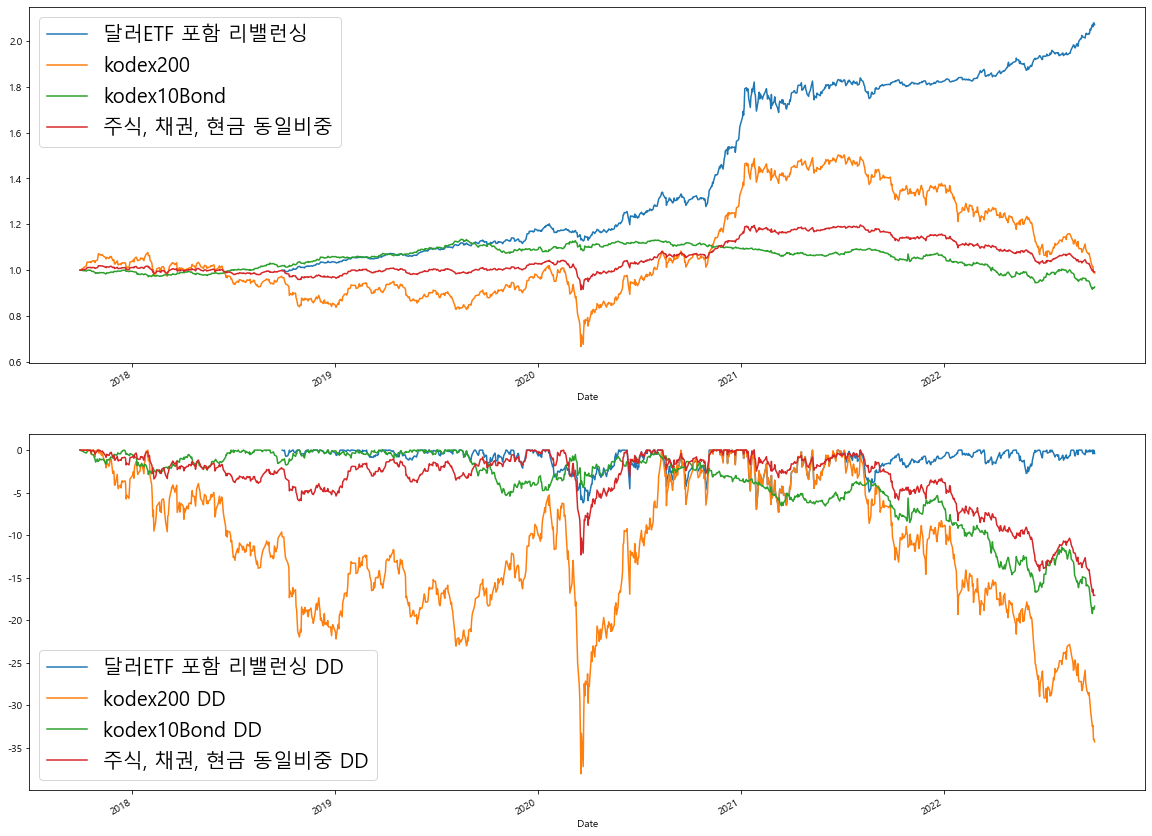

In [13]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
momentum12CumReturn.plot(label="달러ETF 포함 리밸런싱")
kodex200_CumReturn.plot(label="kodex200")
kodex10Bond_CumReturn.plot(label="kodex10Bond")
equalWeight_CumReturn.plot(label="주식, 채권, 현금 동일비중")
plt.legend(fontsize=20)

# dd 곡선
plt.subplot(2,1,2)
(-dd12).plot(label="달러ETF 포함 리밸런싱 DD")
(-kodex200_DD).plot(label="kodex200 DD")
(-kodex10Bond_DD).plot(label="kodex10Bond DD")
(-equalWeight_DD).plot(label="주식, 채권, 현금 동일비중 DD")
plt.legend(fontsize=20)

plt.show()